In [1]:
!pip install langgraph langchain-google-genai pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.5 MB/s eta 0:00:00


In [6]:
from langgraph.graph import StateGraph , START  , END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict , Annotated , Literal
from pydantic import BaseModel , Field
import operator

In [3]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [4]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
    , api_key= api_key)

In [7]:
class SentimentSchema(BaseModel):
  sentiment: Literal["positive" , "negative"] = Field(description = 'Sentiment of the review')


In [8]:
structured_model = model.with_structured_output(SentimentSchema)

In [9]:
prompt = 'what is the sentiment of the review - the product is bad '

In [10]:
structured_model.invoke(prompt).sentiment

'negative'

In [11]:
class ReviewState(TypedDict):
  review : str
  sentiment :Literal["positive" , "negative"]
  diagnosis : dict
  response : str

In [14]:
def find_sentiment(state: ReviewState):
  prompt = f"for the following review find out the sentiment \n {state["review"]}"
  sentiment=structured_model.invoke(prompt).sentiment
  return {'sentiment' :  sentiment}

In [18]:
def check_sentiment(state : ReviewState)-> Literal["positive_response" , "run_diagnosis"]:
  if state['sentiment'] == 'positive':
    return 'positive_response'
  else:
    return 'run_diagnosis'

In [19]:
def positive_response(state : ReviewState):
    prompt = f"Write a warm thankyou message for this review :  \n {state["review"]}"
    response = model.invoke(prompt).content
    return {'response' : response}

In [20]:
class DiagnosisSchema(BaseModel):
  issue_type: Literal["UX" , "Performance" , "Bug" , "Support" , "other"]= Field(description = 'Type of issue')
  tone :  Literal["angry" , "frustrated" , "dissapointed" , "calm"] = Field(description = 'Tone of the reviewer')
  urgency : Literal["high" , "medium" , "low"] = Field(description = 'Urgency of the issue')

In [22]:
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [24]:
def run_diagnosis(state : ReviewState):
  prompt = f"Run a diagnosis on this negative review : \n\n {state['review']} \n Resturn issue type , tone and urgency "
  response = structured_model2.invoke(prompt)
  return {'diagnosis': response.model_dump() }

In [25]:
def negative_response(state :  ReviewState):
  diagnosis = state['diagnosis']
  prompt = f"""You are a support assistant .
  The user had a '{diagnosis['issue_type']}' issue , sounded '{diagnosis['tone']}' , and marked
  urgency as '{diagnosis['urgency']}' ,  write a empathetic , helpful message .
  """
  response = model.invoke(prompt).content
  return {'response' : response}

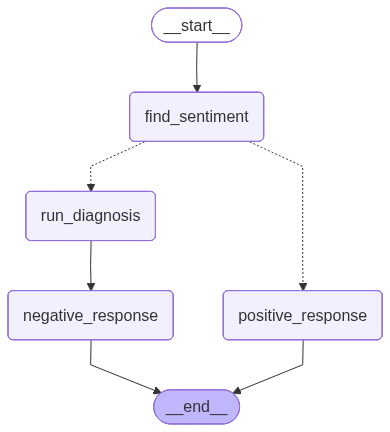

In [28]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment' ,  find_sentiment)
graph.add_node('positive_response' , positive_response)
graph.add_node('run_diagnosis' , run_diagnosis)
graph.add_node('negative_response' , negative_response)

graph.add_edge(START , 'find_sentiment')
graph.add_conditional_edges('find_sentiment' , check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)


graph.compile()

In [29]:
workflow = graph.compile()

In [30]:
initial_state = {
    'review' : 'the product was good '
}
workflow.invoke(initial_state)

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 26.616263813s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '26s'}]}}

In [31]:
initial_state = {
    'review' : 'the on/of button is broken why the hell do you send broken things  '
}
workflow.invoke(initial_state)

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 37.375695741s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '37s'}]}}